# 뇌종양 MRI 세그멘테이션 프로젝트 - HRNetV2 (Part 1: 환경 설정)

이 노트북은 HRNetV2를 사용하여 뇌종양 MRI 세그멘테이션 모델 구축을 위한 환경 설정 과정을 담고 있습니다.


## 개요
1. 환경 설정 및 필요한 패키지 설치
2. HRNet Semantic Segmentation 저장소 클론
3. 프로젝트 디렉토리 구조 설정
4. Google Drive 연결 (선택사항)

## 1. 환경 설정 및 필요한 패키지 설치

먼저 Colab에서 GPU를 사용하도록 설정합니다.
- 메뉴 > 런타임 > 런타임 유형 변경 > 하드웨어 가속기 > GPU 선택

그런 다음 GPU가 할당되었는지 확인합니다.

In [1]:
# GPU 확인
!nvidia-smi

Sun Apr 20 15:10:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   47C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [53]:
# 기본 패키지 설치
!pip install torch torchvision datasets transformers huggingface_hub
!pip install Pillow matplotlib numpy opencv-python
!pip install segmentation-models-pytorch albumentations
!pip install scikit-learn pycocotools

## 2. HRNet Semantic Segmentation 저장소 클론

HRNetV2 세그멘테이션 모델을 포함하는 저장소를 클론합니다.

In [55]:
# HRNet Semantic Segmentation 저장소 클론
!git clone https://github.com/HRNet/HRNet-Semantic-Segmentation.git

# 필요한 의존성 설치
%cd HRNet-Semantic-Segmentation
!pip install -r requirements.txt
%cd ..

In [67]:
# 필요한 디렉토리 생성
!mkdir -p HRNet-Semantic-Segmentation/experiments/brain_tumor
!mkdir -p work_dirs/brain_tumor/log
!mkdir -p pretrained_models


## 3. 프로젝트 디렉토리 구조 설정

필요한 디렉토리 구조를 생성합니다.


In [56]:
# 작업 디렉토리 생성
!mkdir -p brain_tumor_dataset
!mkdir -p brain_tumor_coco
!mkdir -p brain_tumor_coco/images/train
!mkdir -p brain_tumor_coco/images/valid
!mkdir -p brain_tumor_coco/images/test
!mkdir -p work_dirs/brain_tumor
!mkdir -p results

## 4. Google Drive 연결 (선택사항)

긴 학습 세션에서는 학습 체크포인트와 결과를 Google Drive에 저장하는 것이 좋습니다. 세션이 종료되더라도 데이터가 유지됩니다.


In [7]:
# Google Drive 마운트 (선택사항)
from google.colab import drive
drive.mount('/content/drive')

# Drive에 저장 디렉토리 생성
!mkdir -p /content/drive/MyDrive/brain_tumor_project
!mkdir -p /content/drive/MyDrive/brain_tumor_project/checkpoints

Mounted at /content/drive


# 뇌종양 MRI 세그멘테이션 - HRNetV2 (Part 2: 데이터셋 준비)

이 노트북은 뇌종양 MRI 세그멘테이션에 사용될 데이터를 다운로드하고 HRNet-Semantic-Segmentation 모델에 맞게 준비하는 과정을 담고 있습니다.

## 1. 뇌종양 MRI 데이터셋 다운로드

Hugging Face Datasets 라이브러리를 사용하여 뇌종양 MRI 데이터셋을 다운로드합니다:

In [59]:
# Hugging Face 설치 및 데이터셋 다운로드
!pip install datasets
import datasets
from datasets import load_dataset

# 뇌종양 MRI 데이터셋 로드
dataset = load_dataset("dwb2023/brain-tumor-image-dataset-semantic-segmentation", trust_remote_code=True)
print(dataset)

# 데이터셋 정보 출력
print(f"Train samples: {len(dataset['train'])}")
print(f"Test samples: {len(dataset['test'])}")

## 2. 데이터셋 디렉토리 생성

HRNet-Semantic-Segmentation에서 사용하기 위한 디렉토리 구조를 생성합니다:

In [60]:
# 데이터셋 디렉토리 생성
!mkdir -p brain_tumor_data/images/train
!mkdir -p brain_tumor_data/images/valid
!mkdir -p brain_tumor_data/images/test
!mkdir -p brain_tumor_data/annotations

## 3. 데이터셋을 COCO 포맷으로 변환

HRNet 모델 학습을 위해 데이터셋을 COCO 포맷으로 변환합니다:

In [115]:
import os
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import cv2

def create_coco_dataset(dataset_split, output_dir, split_name, start_id=0):
    """데이터셋을 COCO 포맷으로 변환"""
    # COCO 포맷 기본 구조
    coco_format = {
        "images": [],
        "annotations": [],
        "categories": [
            {
                "id": 1,
                "name": "tumor",
                "supercategory": "medical"
            }
        ]
    }

    image_id = start_id
    annotation_id = start_id

    # 데이터셋의 각 이미지에 대해 처리
    for item in tqdm(dataset_split, desc=f"Processing {split_name} dataset"):
        # 이미지 정보 추출 - 키 이름 확인
        if 'image' in item and 'mask' in item:
            image = item['image']
            mask = item['mask']
        elif 'image' in item and 'segmentation_mask' in item:
            image = item['image']
            mask = item['segmentation_mask']
        else:
            # 필요한 키 확인을 위해 첫 번째 항목 출력
            print(f"데이터셋 구조 확인: {list(item.keys())}")
            continue

        # 이미지 크기 얻기
        if hasattr(image, 'shape'):
            height, width = image.shape[0], image.shape[1]
        elif hasattr(image, 'size'):
            width, height = image.size
        else:
            print(f"이미지 크기를 결정할 수 없습니다: {type(image)}")
            continue

        # 파일명 생성
        file_name = f"{split_name}_{image_id:06d}.png"
        image_path = os.path.join(output_dir, "images", split_name, file_name)

        # 이미지 저장
        try:
            if isinstance(image, np.ndarray):
                img_pil = Image.fromarray(image)
            else:
                img_pil = image
            img_pil.save(image_path)
        except Exception as e:
            print(f"이미지 저장 오류: {e}")
            continue

        # 이미지 정보 추가
        coco_format["images"].append({
            "id": image_id,
            "file_name": file_name,
            "height": height,
            "width": width,
        })

        # 마스크에서 종양 영역 찾기
        try:
            if isinstance(mask, np.ndarray):
                binary_mask = (mask > 0).astype(np.uint8)
            else:
                binary_mask = np.array(mask)
                binary_mask = (binary_mask > 0).astype(np.uint8)

            # 마스크 저장 (디버깅 목적)
            mask_path = os.path.join(output_dir, "debug_masks", split_name, f"mask_{image_id:06d}.png")
            os.makedirs(os.path.dirname(mask_path), exist_ok=True)
            Image.fromarray(binary_mask * 255).save(mask_path)

            # 종양 영역(마스크)이 있는 경우 어노테이션 추가
            if np.sum(binary_mask) > 0:
                # OpenCV 윤곽선 찾기
                contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                for contour in contours:
                    # 너무 작은 윤곽선은 건너뛰기
                    if cv2.contourArea(contour) < 10:
                        continue

                    # COCO 세그멘테이션 포맷으로 변환 (다각형)
                    segmentation = contour.flatten().tolist()

                    # 너무 작은 세그멘테이션은 건너뛰기
                    if len(segmentation) <= 4:  # 최소 3개의 점이 필요
                        continue

                    # 바운딩 박스 계산
                    x, y, w, h = cv2.boundingRect(contour)
                    bbox = [x, y, w, h]

                    # 영역 넓이 계산
                    area = cv2.contourArea(contour)

                    # 어노테이션 정보 추가
                    coco_format["annotations"].append({
                        "id": annotation_id,
                        "image_id": image_id,
                        "category_id": 1,  # 종양 카테고리
                        "segmentation": [segmentation],
                        "area": area,
                        "bbox": bbox,
                        "iscrowd": 0,
                    })

                    annotation_id += 1
        except Exception as e:
            print(f"마스크 처리 오류: {e}")
            continue

        image_id += 1

    # COCO 포맷 JSON 저장
    json_path = os.path.join(output_dir, f"{split_name}.json")
    with open(json_path, 'w') as f:
        json.dump(coco_format, f)

    print(f"{split_name} 데이터셋: {len(coco_format['images'])} 이미지, {len(coco_format['annotations'])} 어노테이션")
    return image_id, annotation_id

# 데이터셋 분할
train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15

# 전체 데이터셋을 합치고 섞기
full_dataset = []
full_dataset.extend(dataset['train'])
full_dataset.extend(dataset['test'])
random.shuffle(full_dataset)

# 데이터셋 분할
n_samples = len(full_dataset)
n_train = int(n_samples * train_ratio)
n_valid = int(n_samples * valid_ratio)

train_dataset = full_dataset[:n_train]
valid_dataset = full_dataset[n_train:n_train+n_valid]
test_dataset = full_dataset[n_train+n_valid:]

print(f"Split sizes - Train: {len(train_dataset)}, Valid: {len(valid_dataset)}, Test: {len(test_dataset)}")

# COCO 포맷으로 변환
next_id, next_ann_id = create_coco_dataset(train_dataset, "brain_tumor_data", "train")
next_id, next_ann_id = create_coco_dataset(valid_dataset, "brain_tumor_data", "valid", next_id)
_, _ = create_coco_dataset(test_dataset, "brain_tumor_data", "test", next_id)

print("데이터셋이 COCO 포맷으로 성공적으로 변환되었습니다.")

In [117]:
# COCO 형식으로 변환 실행
!python convert_to_coco.py

Loading dataset from Hugging Face...
Converting train split to COCO format...
Saved train COCO format data to brain_tumor_coco/train.json
- Images saved: 1502
- Annotations saved: 0
Converting valid split to COCO format...
Saved valid COCO format data to brain_tumor_coco/valid.json
- Images saved: 429
- Annotations saved: 0
Converting test split to COCO format...
Saved test COCO format data to brain_tumor_coco/test.json
- Images saved: 215
- Annotations saved: 0
Conversion to COCO format completed. Output directory: brain_tumor_coco


## 4. 데이터셋 샘플 시각화



In [122]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from datasets import load_dataset

# 데이터셋 샘플 시각화 및 검증
def visualize_dataset_samples(dataset, num_samples=5):
    """
    데이터셋 샘플을 시각화하여 형식 확인
    """
    # 랜덤하게 샘플 선택
    indices = np.random.choice(len(dataset), min(num_samples, len(dataset)), replace=False)

    plt.figure(figsize=(12, 4*num_samples))

    for i, idx in enumerate(indices):
        # numpy.int64를 Python int로 변환 (중요 수정!)
        idx = int(idx)

        sample = dataset[idx]

        # 키 확인
        print(f"샘플 {idx} 키: {list(sample.keys())}")

        # 이미지 및 세그멘테이션 정보 추출
        if 'image' not in sample:
            print(f"샘플 {idx}에서 이미지를 찾을 수 없습니다")
            continue

        image = sample['image']

        # 세그멘테이션 정보 확인
        has_segmentation = False
        if 'segmentation' in sample and sample['segmentation']:
            has_segmentation = True
            print(f"세그멘테이션 형식: {type(sample['segmentation'])}")

        # 이미지 타입 확인
        print(f"이미지 타입: {type(image)}")

        # 이미지를 numpy 배열로 변환
        if not isinstance(image, np.ndarray):
            try:
                image = np.array(image)
            except Exception as e:
                print(f"이미지 변환 오류: {e}")
                continue

        print(f"이미지 형태: {image.shape}, 값 범위: {image.min()}-{image.max()}")

        # 이미지 시각화
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(image)
        plt.title(f"원본 이미지 {idx}")
        plt.axis('off')

        # 세그멘테이션 다각형이 있는 경우 마스크 생성
        if has_segmentation:
            # 빈 마스크 생성
            h, w = sample['height'], sample['width']
            mask = np.zeros((h, w), dtype=np.uint8)

            # 세그멘테이션 다각형 그리기
            segmentations = sample['segmentation']
            if isinstance(segmentations, list):
                for seg in segmentations:
                    if isinstance(seg, list) and len(seg) >= 6:  # 최소 3개의 점이 필요
                        # seg는 [x1, y1, x2, y2, ...] 형식
                        points = np.array(seg).reshape(-1, 2)
                        cv2.fillPoly(mask, [points.astype(np.int32)], 1)

            plt.subplot(num_samples, 3, i*3 + 2)
            plt.imshow(mask, cmap='gray')
            plt.title(f"마스크 {idx}")
            plt.axis('off')

            # 이미지에 마스크 오버레이
            overlay = image.copy()
            if len(overlay.shape) == 2:  # 그레이스케일 이미지
                overlay = np.stack([overlay] * 3, axis=2)
            overlay_mask = np.zeros_like(overlay)
            if len(overlay.shape) == 3 and overlay.shape[2] >= 3:
                overlay_mask[:, :, 0] = mask * 255  # 빨간색 채널
                overlay_result = cv2.addWeighted(overlay, 0.7, overlay_mask, 0.3, 0)
                plt.subplot(num_samples, 3, i*3 + 3)
                plt.imshow(overlay_result)
                plt.title(f"오버레이 {idx}")
                plt.axis('off')
        else:
            print(f"샘플 {idx}에는 세그멘테이션 정보가 없습니다")

    plt.title(f"원본 이미지 {idx}")
    plt.title(f"마스크 {idx}")
    plt.title(f"오버레이 {idx}")
    plt.tight_layout()
    plt.show()

# 데이터셋 로드
try:
    # 데이터셋 로드
    dataset = load_dataset("dwb2023/brain-tumor-image-dataset-semantic-segmentation")
    print(f"데이터셋 구조: {dataset}")

    # 데이터셋 형식 분석
    print("\n데이터셋 상세 정보:")
    for split_name, split_data in dataset.items():
        print(f"\n{split_name} 분할: {len(split_data)}개 샘플")

        # 첫 번째 샘플의 키와 값 형식 보기
        if len(split_data) > 0:
            sample = split_data[0]
            print("첫 번째 샘플 정보:")
            for key, value in sample.items():
                print(f"  - {key}: {type(value)}")
                if key == 'segmentation' and value:
                    print(f"    세그멘테이션 형식: {type(value[0])}, 길이: {len(value)}")
                    if len(value) > 0 and isinstance(value[0], list):
                        print(f"    첫 번째 다각형 포인트 수: {len(value[0]) // 2}")

    # 샘플 시각화
    print("\n샘플 이미지 시각화:")
    visualize_dataset_samples(dataset['train'])

except Exception as e:
    print(f"데이터셋 로드 또는 시각화 중 오류 발생: {e}")
    import traceback
    traceback.print_exc()

## 5. HRNet-Semantic-Segmentation 설정

HRNet-Semantic-Segmentation 모델에서 사용하기 위한 설정을 완료합니다:

In [123]:
# config.yaml 파일 생성
%%writefile HRNet-Semantic-Segmentation/experiments/brain_tumor/seg_hrnet_w48_train_640x640_sgd_lr1e-2_wd5e-4_bs_8_epoch40.yaml
CUDNN:
  BENCHMARK: true
  DETERMINISTIC: false
  ENABLED: true
GPUS: (0,)
OUTPUT_DIR: 'work_dirs/brain_tumor'
LOG_DIR: 'work_dirs/brain_tumor/log'
WORKERS: 4
PRINT_FREQ: 100

DATASET:
  DATASET: brain_tumor
  ROOT: 'brain_tumor_data/'
  NUM_CLASSES: 2
  TRAIN_SET: 'train'
  TEST_SET: 'valid'

MODEL:
  NAME: seg_hrnet
  PRETRAINED: 'pretrained_models/hrnetv2_w48_imagenet_pretrained.pth'
  EXTRA:
    FINAL_CONV_KERNEL: 1
    STAGE1:
      NUM_MODULES: 1
      NUM_RANCHES: 1
      BLOCK: BOTTLENECK
      NUM_BLOCKS:
      - 4
      NUM_CHANNELS:
      - 64
      FUSE_METHOD: SUM
    STAGE2:
      NUM_MODULES: 1
      NUM_BRANCHES: 2
      BLOCK: BASIC
      NUM_BLOCKS:
      - 4
      - 4
      NUM_CHANNELS:
      - 48
      - 96
      FUSE_METHOD: SUM
    STAGE3:
      NUM_MODULES: 4
      NUM_BRANCHES: 3
      BLOCK: BASIC
      NUM_BLOCKS:
      - 4
      - 4
      - 4
      NUM_CHANNELS:
      - 48
      - 96
      - 192
      FUSE_METHOD: SUM
    STAGE4:
      NUM_MODULES: 3
      NUM_BRANCHES: 4
      BLOCK: BASIC
      NUM_BLOCKS:
      - 4
      - 4
      - 4
      - 4
      NUM_CHANNELS:
      - 48
      - 96
      - 192
      - 384
      FUSE_METHOD: SUM

TRAIN:
  IMAGE_SIZE:
  - 640
  - 640
  BASE_SIZE: 640
  BATCH_SIZE_PER_GPU: 8
  SHUFFLE: true
  BEGIN_EPOCH: 0
  END_EPOCH: 40
  RESUME: false
  OPTIMIZER: sgd
  LR: 0.01
  WD: 0.0005
  MOMENTUM: 0.9
  NESTEROV: false
  FLIP: true
  MULTI_SCALE: true
  DOWNSAMPLERATE: 1
  IGNORE_LABEL: 255
  SCALE_FACTOR: 16

TEST:
  IMAGE_SIZE:
  - 640
  - 640
  BASE_SIZE: 640
  BATCH_SIZE_PER_GPU: 8
  FLIP_TEST: false
  MULTI_SCALE: false

Overwriting HRNet-Semantic-Segmentation/experiments/brain_tumor/seg_hrnet_w48_train_640x640_sgd_lr1e-2_wd5e-4_bs_8_epoch40.yaml


## 6. 처음부터 학습하기 (사전 훈련된 모델 없이)
처음부터 학습하기 (사전 훈련된 모델 없이):

In [124]:
# config 파일에서 PRETRAINED 경로 제거
!sed -i "s|PRETRAINED: 'pretrained_models/hrnetv2_w48_imagenet_pretrained.pth'|PRETRAINED: ''|g" HRNet-Semantic-Segmentation/experiments/brain_tumor/seg_hrnet_w48_train_640x640_sgd_lr1e-2_wd5e-4_bs_8_epoch40.yaml

# 뇌종양 MRI 세그멘테이션 - HRNetV2 (Part 3: 모델 설정 및 학습)

이 부분에서는 HRNet-Semantic-Segmentation 저장소를 사용하여 뇌종양 MRI 세그멘테이션 모델을 설정하고 학습하는 과정을 다룹니다.


## 1. 모델 설정 파일 생성

HRNetV2 세그멘테이션 모델을 위한 구성 파일을 생성합니다:

In [125]:
%%writefile brain_tumor_config.py
import os

# 기본 설정
_C = {}

# 기본 경로 설정
_C['OUTPUT_DIR'] = 'work_dirs/brain_tumor'
_C['LOG_DIR'] = 'work_dirs/brain_tumor/log'
_C['GPUS'] = (0,)
_C['WORKERS'] = 4
_C['PRINT_FREQ'] = 20
_C['AUTO_RESUME'] = True
_C['PIN_MEMORY'] = True
_C['RANK'] = 0

# 세그멘테이션 모델 설정
_C['MODEL'] = {
    'NAME': 'seg_hrnet',
    'PRETRAINED': 'pretrained_models/hrnetv2_w48_imagenet_pretrained.pth',
    'EXTRA': {
        'FINAL_CONV_KERNEL': 1,
        'STAGE1': {
            'NUM_MODULES': 1,
            'NUM_RANCHES': 1,
            'BLOCK': 'BOTTLENECK',
            'NUM_BLOCKS': [4],
            'NUM_CHANNELS': [64],
            'FUSE_METHOD': 'SUM'
        },
        'STAGE2': {
            'NUM_MODULES': 1,
            'NUM_BRANCHES': 2,
            'BLOCK': 'BASIC',
            'NUM_BLOCKS': [4, 4],
            'NUM_CHANNELS': [48, 96],
            'FUSE_METHOD': 'SUM'
        },
        'STAGE3': {
            'NUM_MODULES': 4,
            'NUM_BRANCHES': 3,
            'BLOCK': 'BASIC',
            'NUM_BLOCKS': [4, 4, 4],
            'NUM_CHANNELS': [48, 96, 192],
            'FUSE_METHOD': 'SUM'
        },
        'STAGE4': {
            'NUM_MODULES': 3,
            'NUM_BRANCHES': 4,
            'BLOCK': 'BASIC',
            'NUM_BLOCKS': [4, 4, 4, 4],
            'NUM_CHANNELS': [48, 96, 192, 384],
            'FUSE_METHOD': 'SUM'
        }
    }
}

# 데이터셋 설정
_C['DATASET'] = {
    'DATASET': 'brain_tumor',
    'ROOT': 'brain_tumor_coco/',
    'TEST_SET': 'test',
    'TRAIN_SET': 'train',
    'NUM_CLASSES': 2,  # 배경과 종양
    'NUM_JOINTS': 17,  # 사용하지 않음, hrnet 기본값 유지
}

# 학습 설정
_C['TRAIN'] = {
    'IMAGE_SIZE': [640, 640],  # 원본 크기에 맞춤
    'BASE_SIZE': 640,
    'BATCH_SIZE_PER_GPU': 8,
    'SHUFFLE': True,
    'BEGIN_EPOCH': 0,
    'END_EPOCH': 10,
    'RESUME': False,
    'OPTIMIZER': 'sgd',
    'LR': 0.01,
    'WD': 0.0001,
    'MOMENTUM': 0.9,
    'NESTEROV': False,
    'FLIP': True,
    'MULTI_SCALE': True,
    'DOWNSAMPLERATE': 1,
    'IGNORE_LABEL': 255,
    'SCALE_FACTOR': 16,
}

# 검증 설정
_C['TEST'] = {
    'IMAGE_SIZE': [640, 640],  # 원본 크기에 맞춤
    'BASE_SIZE': 640,
    'BATCH_SIZE_PER_GPU': 4,
    'FLIP_TEST': False,
    'MULTI_SCALE': False,
    'MODEL_FILE': '',
}

Overwriting brain_tumor_config.py



## 2. 데이터셋 어댑터 생성

모델 학습을 위한 스크립트를 생성합니다:

In [126]:
%%writefile brain_tumor_dataset.py
import os
import json
import numpy as np
import cv2
from PIL import Image

import torch
from torch.utils.data import Dataset

class BrainTumorDataset(Dataset):
    def __init__(self, root, split='train', transform=None):
        """
        뇌종양 MRI 세그멘테이션 데이터셋
        Args:
            root (str): 데이터셋 루트 경로
            split (str): 'train', 'valid', 'test' 중 하나
            transform: 데이터 변환
        """
        self.root = root
        self.split = split
        self.transform = transform
        self.img_dir = os.path.join(root, 'images', split)
        self.json_file = os.path.join(root, f'{split}.json')

        # COCO 포맷 데이터 로드
        with open(self.json_file, 'r') as f:
            self.coco_data = json.load(f)

        self.images = self.coco_data['images']
        self.annotations = self.coco_data['annotations']

        # 이미지별 어노테이션 매핑
        self.img_to_anns = {}
        for ann in self.annotations:
            img_id = ann['image_id']
            if img_id not in self.img_to_anns:
                self.img_to_anns[img_id] = []
            self.img_to_anns[img_id].append(ann)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_info = self.images[idx]
        img_id = img_info['id']
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        # 이미지 로드
        img = Image.open(img_path).convert('RGB')
        width, height = img_info['width'], img_info['height']

        # 세그멘테이션 마스크 생성 (배경=0, 종양=1)
        mask = np.zeros((height, width), dtype=np.uint8)

        if img_id in self.img_to_anns:
            for ann in self.img_to_anns[img_id]:
                if 'segmentation' in ann:
                    # 세그멘테이션 다각형을 마스크로 변환
                    if isinstance(ann['segmentation'], list):
                        for seg in ann['segmentation']:
                            poly = np.array(seg).reshape((-1, 2))
                            cv2.fillPoly(mask, [poly.astype(np.int32)], 1)

        # 이미지와 마스크를 numpy 배열로 변환
        img = np.array(img)

        # 변환 적용 (있는 경우)
        if self.transform:
            img, mask = self.transform(img, mask)

        return img, mask

Overwriting brain_tumor_dataset.py


## 3. 학습 스크립트 생성

HRNet-Semantic-Segmentation을 학습시키기 위한 스크립트를 작성합니다:

In [127]:
%%writefile train_brain_tumor.py
import os
import argparse
import pprint
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import sys
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import logging
import torch.nn.functional as F
import json

# 로깅 설정
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger('brain_tumor')

# BasicBlock 정의
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = None
        if stride != 1 or inplanes != planes * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

# 간소화된 HRNet 모델
class SimpleHRNet(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleHRNet, self).__init__()

        # 입력 스템 레이어
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Bottleneck 블록
        self.layer1 = self._make_layer(64, 64, 4)

        # 두 개의 병렬 브랜치
        self.layer2_1 = self._make_layer(64, 64, 4)
        self.layer2_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            self._make_layer(128, 128, 4)
        )

        # 세 개의 병렬 브랜치
        self.layer3_1 = self._make_layer(64, 64, 4)
        self.layer3_2 = self._make_layer(128, 128, 4)
        self.layer3_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            self._make_layer(256, 256, 4)
        )

        # 최종 분류 레이어
        self.fuse_layers = nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=1, bias=False),
            nn.Sequential(
                nn.Conv2d(128, 64, kernel_size=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
            ),
            nn.Sequential(
                nn.Conv2d(256, 64, kernel_size=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)
            )
        ])

        self.final_layer = nn.Conv2d(64, num_classes, kernel_size=1)

    def _make_layer(self, inplanes, planes, blocks):
        layers = []
        for i in range(blocks):
            layers.append(BasicBlock(inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        # 스템
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        # 레이어 1
        x = self.layer1(x)

        # 레이어 2 - 두 개의 병렬 브랜치
        x1 = self.layer2_1(x)
        x2 = self.layer2_2(x)

        # 레이어 3 - 세 개의 병렬 브랜치
        x1 = self.layer3_1(x1)
        x2 = self.layer3_2(x2)
        x3 = self.layer3_3(x2)

        # 특징 융합
        x1_fuse = self.fuse_layers[0](x1)
        x2_fuse = self.fuse_layers[1](x2)
        x3_fuse = self.fuse_layers[2](x3)

        x_fuse = x1_fuse + x2_fuse + x3_fuse

        # 업샘플링 및 최종 예측
        x_out = self.final_layer(x_fuse)
        x_out = F.interpolate(x_out, scale_factor=4, mode='bilinear', align_corners=False)

        return x_out

# 데이터셋 클래스
class BrainTumorDataset(torch.utils.data.Dataset):
    def __init__(self, root, split='train', transform=None):
        self.root = root
        self.split = split
        self.transform = transform
        self.img_dir = os.path.join(root, 'images', split)
        self.json_file = os.path.join(root, f'{split}.json')

        # COCO 포맷 데이터 로드
        with open(self.json_file, 'r') as f:
            self.coco_data = json.load(f)

        self.images = self.coco_data['images']
        self.annotations = self.coco_data['annotations']

        # 이미지별 어노테이션 매핑
        self.img_to_anns = {}
        for ann in self.annotations:
            img_id = ann['image_id']
            if img_id not in self.img_to_anns:
                self.img_to_anns[img_id] = []
            self.img_to_anns[img_id].append(ann)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        import cv2
        import numpy as np

        img_info = self.images[idx]
        img_id = img_info['id']
        img_path = os.path.join(self.img_dir, img_info['file_name'])

        # 이미지 로드
        img = cv2.imread(img_path)
        if img is None:
            logger.error(f"이미지를 로드할 수 없습니다: {img_path}")
            # 더미 이미지 반환
            img = np.zeros((640, 640, 3), dtype=np.uint8)
            mask = np.zeros((640, 640), dtype=np.uint8)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # 세그멘테이션 마스크 생성 (배경=0, 종양=1)
            mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)

            if img_id in self.img_to_anns:
                for ann in self.img_to_anns[img_id]:
                    if 'segmentation' in ann:
                        # 세그멘테이션 다각형을 마스크로 변환
                        if isinstance(ann['segmentation'], list):
                            for seg in ann['segmentation']:
                                poly = np.array(seg).reshape((-1, 2))
                                cv2.fillPoly(mask, [poly.astype(np.int32)], 1)

        # 크기 조정 (이미지 크기가 다를 수 있으므로)
        if img.shape[0] != 640 or img.shape[1] != 640:
            img = cv2.resize(img, (640, 640))
            mask = cv2.resize(mask, (640, 640), interpolation=cv2.INTER_NEAREST)

        # 변환 적용 (있는 경우)
        if self.transform:
            try:
                augmented = self.transform(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']
            except Exception as e:
                logger.error(f"변환 오류: {e}")

        # PyTorch 텐서로 변환
        img = torch.from_numpy(img.transpose(2, 0, 1)).float() / 255.0
        mask = torch.from_numpy(mask).long()

        return img, mask

# 설정 파일 로드
def parse_args():
    parser = argparse.ArgumentParser(description='Train segmentation network')
    parser.add_argument('--seed', type=int, default=42, help='random seed')
    parser.add_argument('--epochs', type=int, default=10, help='number of epochs')
    parser.add_argument('--batch-size', type=int, default=8, help='batch size')
    parser.add_argument('--lr', type=float, default=0.01, help='learning rate')
    parser.add_argument('--work-dir', type=str, default='work_dirs/brain_tumor', help='working directory')
    args = parser.parse_args()
    return args

def main():
    args = parse_args()

    # 시드 설정
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed(args.seed)
    cudnn.benchmark = True
    cudnn.deterministic = False

    # 모델 생성
    model = SimpleHRNet(num_classes=2)
    logger.info(f"모델 생성 완료: {type(model).__name__}")

    # 손실 함수 및 옵티마이저 설정
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=0.0001)

    # 학습률 스케줄러
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [30, 60], 0.1)

    # GPU 사용 설정
    model = nn.DataParallel(model).cuda()

    # 데이터셋 및 데이터 로더 생성
    try:
        import albumentations as A
        from albumentations.pytorch import ToTensorV2

        train_transform = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        val_transform = A.Compose([
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
    except ImportError:
        logger.warning("albumentations 라이브러리가 설치되지 않았습니다. 기본 변환만 사용됩니다.")
        train_transform = None
        val_transform = None

    try:
        train_dataset = BrainTumorDataset(
            root='brain_tumor_data',
            split='train',
            transform=train_transform
        )

        val_dataset = BrainTumorDataset(
            root='brain_tumor_data',
            split='valid',
            transform=val_transform
        )

        train_loader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=args.batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            drop_last=True
        )

        val_loader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=args.batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True
        )

        logger.info(f"데이터셋 로드 완료 - 학습: {len(train_dataset)}개, 검증: {len(val_dataset)}개")
    except Exception as e:
        logger.error(f"데이터셋 로드 오류: {e}")
        import traceback
        traceback.print_exc()
        return

    # 저장 디렉토리 생성
    os.makedirs(args.work_dir, exist_ok=True)

    # 학습 시작
    logger.info("학습 시작...")
    best_miou = 0

    for epoch in range(args.epochs):
        # 학습
        train_loss = train_one_epoch(train_loader, model, criterion, optimizer, epoch)

        # 검증
        val_loss, miou = validate(val_loader, model, criterion)

        # 학습률 업데이트
        lr_scheduler.step()

        # 로그 출력
        logger.info(f"Epoch {epoch+1}/{args.epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, mIoU: {miou:.4f}")

        # 체크포인트 저장
        if miou > best_miou:
            best_miou = miou
            checkpoint_path = os.path.join(args.work_dir, 'best_model.pth')
            torch.save({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'best_miou': best_miou,
            }, checkpoint_path)
            logger.info(f"Best model saved to {checkpoint_path}")

    logger.info(f"학습 완료. 최고 mIoU: {best_miou:.4f}")

def train_one_epoch(train_loader, model, criterion, optimizer, epoch):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for images, targets in pbar:
        images = images.cuda()
        targets = targets.cuda()

        # 순전파
        outputs = model(images)
        loss = criterion(outputs, targets)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 손실 업데이트
        running_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    return running_loss / len(train_loader)

def validate(val_loader, model, criterion):
    model.eval()
    running_loss = 0.0
    intersections = 0
    unions = 0

    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc="Validating"):
            images = images.cuda()
            targets = targets.cuda()

            # 순전파
            outputs = model(images)
            loss = criterion(outputs, targets)

            # 손실 업데이트
            running_loss += loss.item()

            # IoU 계산
            preds = outputs.argmax(1)
            intersect = ((preds == 1) & (targets == 1)).sum().item()
            union = ((preds == 1) | (targets == 1)).sum().item()

            intersections += intersect
            unions += union

    # mIoU 계산 (평균 IoU)
    miou = intersections / (unions + 1e-10)

    return running_loss / len(val_loader), miou

if __name__ == '__main__':
    main()

Overwriting train_brain_tumor.py


## 4. 모델 학습 실행

학습 스크립트를 실행하여 모델을 학습합니다:

In [92]:
# 필요한 라이브러리 설치
!pip install albumentations --quiet

# 모델 훈련 시작
!python train_brain_tumor.py --epochs 10 --batch-size 8 --lr 0.01

2025-04-20 19:16:55,804 - brain_tumor - INFO - 모델 생성 완료: SimpleHRNet
2025-04-20 19:17:01,545 - brain_tumor - INFO - 데이터셋 로드 완료 - 학습: 1201개, 검증: 257개
2025-04-20 19:17:01,545 - brain_tumor - INFO - 학습 시작...
Epoch 1: 100% 150/150 [00:45<00:00,  3.30it/s, loss=0.0927]
Validating: 100% 33/33 [00:03<00:00,  9.43it/s]
2025-04-20 19:17:50,490 - brain_tumor - INFO - Epoch 1/10 - Train Loss: 0.1431, Val Loss: 0.1138, mIoU: 0.0179
2025-04-20 19:17:50,609 - brain_tumor - INFO - Best model saved to work_dirs/brain_tumor/best_model.pth
Epoch 2: 100% 150/150 [00:44<00:00,  3.36it/s, loss=0.0685]
Validating: 100% 33/33 [00:03<00:00,  9.99it/s]
2025-04-20 19:18:38,529 - brain_tumor - INFO - Epoch 2/10 - Train Loss: 0.1075, Val Loss: 0.0998, mIoU: 0.2611
2025-04-20 19:18:38,700 - brain_tumor - INFO - Best model saved to work_dirs/brain_tumor/best_model.pth
Epoch 3: 100% 150/150 [00:45<00:00,  3.30it/s, loss=0.0761]
Validating: 100% 33/33 [00:03<00:00, 10.19it/s]
2025-04-20 19:19:27,460 - brain_tumor - I

학습에 시간이 오래 걸릴 수 있으므로, 학습 시간을 단축하기 위해 에포크 수를 줄여 테스트할 수 있습니다:

In [49]:
# 빠른 테스트를 위한 학습 실행 (에포크 수 축소)
!python train_brain_tumor.py --epochs 3 --batch-size 8 --lr 0.01 --work-dir work_dirs/brain_tumor

from __future__ import division

import os
import argparse
from mmengine.config import Config

from mmdet import __version__
from mmdet.datasets import get_dataset
from mmdet.apis import (train_detector, init_dist, get_root_logger,
                        set_random_seed)
from mmdet.models import build_detector
import torch


def parse_args():
    parser = argparse.ArgumentParser(description='Train a detector')
    parser.add_argument('config', help='train config file path')
    parser.add_argument('--work_dir', help='the dir to save logs and models')
    parser.add_argument(
        '--resume_from', help='the checkpoint file to resume from')


## 5. Google Drive에 학습 결과 저장 (선택사항)
학습 결과를 Google Drive에 저장하려면:

In [93]:
# 학습 결과를 Google Drive에 복사
!cp -r work_dirs/brain_tumor /content/drive/MyDrive/brain_tumor_project/checkpoints/

학습에 시간이 오래 걸릴 수 있으므로, 학습 시간을 단축하기 위해 에포크 수를 줄이는 방법:

## 6. 학습 중 손실(Loss) 모니터링

학습 로그 파일을 파싱하여 손실(loss)을 모니터링합니다:

In [96]:
import matplotlib.pyplot as plt
import re
import numpy as np
import glob
import os

# 작업 디렉토리 확인
print(f"현재 작업 디렉토리: {os.getcwd()}")

# 로그 디렉토리 확인
log_dir = 'work_dirs/brain_tumor'
print(f"로그 디렉토리 내용:")
if os.path.exists(log_dir):
    print(os.listdir(log_dir))

    # log 하위 디렉토리 확인
    log_subdir = os.path.join(log_dir, 'log')
    if os.path.exists(log_subdir) and os.path.isdir(log_subdir):
        print(f"\nlog 하위 디렉토리 내용:")
        print(os.listdir(log_subdir))
else:
    print(f"디렉토리가 존재하지 않음: {log_dir}")

# 직접 로그 파일 검색
log_files = []

# 모든 가능한 위치 검색
for root, dirs, files in os.walk('work_dirs'):
    for file in files:
        if file.endswith('.log') or file.endswith('.txt'):
            log_files.append(os.path.join(root, file))

# 학습 로그 찾기
print(f"\n찾은 로그 파일 목록: {log_files}")

if log_files:
    latest_log = sorted(log_files)[-1]
    print(f"최신 로그 파일: {latest_log}")

    # 로그 파일 내용 확인
    print("\n로그 파일 내용 샘플:")
    with open(latest_log, 'r') as f:
        lines = f.readlines()
        for line in lines[:10]:  # 처음 10줄만 출력
            print(line.strip())

    # 새로운 로그 형식에 맞는 패턴 찾기
    epochs = []
    train_losses = []
    val_losses = []
    mious = []

    # 수정된 로그 패턴 (SimpleHRNet 코드의 로깅 형식에 맞춤)
    pattern = r"Epoch (\d+)/\d+ - Train Loss: ([\d\.]+), Val Loss: ([\d\.]+), mIoU: ([\d\.]+)"

    with open(latest_log, 'r') as f:
        for line in f:
            match = re.search(pattern, line)
            if match:
                epochs.append(int(match.group(1)))
                train_losses.append(float(match.group(2)))
                val_losses.append(float(match.group(3)))
                mious.append(float(match.group(4)))

    if epochs:
        # 학습 곡선 시각화
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_losses, 'o-', label='Train Loss')
        plt.plot(epochs, val_losses, 'o-', label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Curves')
        plt.grid(True)
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, mious, 'o-', label='Mean IoU')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.title('Validation Metrics')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()
    else:
        print("로그 파일에서 학습 데이터를 찾을 수 없습니다.")

        # 다른 패턴 시도
        print("\n다른 로그 패턴 검색 중...")
        alternative_patterns = [
            r"brain_tumor.*Epoch.*(\d+).*Train Loss.*?([\d\.]+).*Val Loss.*?([\d\.]+).*mIoU.*?([\d\.]+)",
            r"Epoch.*?(\d+).*?loss.*?([\d\.]+).*?val.*?loss.*?([\d\.]+).*?iou.*?([\d\.]+)",
            r".*epoch.*?(\d+).*?train.*?loss.*?([\d\.]+).*?val.*?loss.*?([\d\.]+).*?miou.*?([\d\.]+)"
        ]

        for alt_pattern in alternative_patterns:
            epochs = []
            train_losses = []
            val_losses = []
            mious = []

            with open(latest_log, 'r') as f:
                for line in f:
                    match = re.search(alt_pattern, line, re.IGNORECASE)
                    if match:
                        epochs.append(int(match.group(1)))
                        train_losses.append(float(match.group(2)))
                        val_losses.append(float(match.group(3)))
                        mious.append(float(match.group(4)))

            if epochs:
                print(f"대체 패턴으로 {len(epochs)}개의 에폭 데이터를 찾았습니다!")
                # 학습 곡선 시각화
                plt.figure(figsize=(15, 5))

                plt.subplot(1, 2, 1)
                plt.plot(epochs, train_losses, 'o-', label='Train Loss')
                plt.plot(epochs, val_losses, 'o-', label='Validation Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title('Loss Curves')
                plt.grid(True)
                plt.legend()

                plt.subplot(1, 2, 2)
                plt.plot(epochs, mious, 'o-', label='Mean IoU')
                plt.xlabel('Epoch')
                plt.ylabel('Score')
                plt.title('Validation Metrics')
                plt.grid(True)
                plt.legend()

                plt.tight_layout()
                plt.show()
                break
        else:
            print("모든 패턴을 시도했지만 학습 데이터를 찾을 수 없습니다.")

            # 로그 파일 전체 내용 출력
            print("\n로그 파일 전체 내용:")
            with open(latest_log, 'r') as f:
                print(f.read())
else:
    print("로그 파일을 찾을 수 없습니다. 학습 출력에서 로그 정보를 확인하세요.")

    # 대안: best_model.pth 파일 확인
    model_path = os.path.join(log_dir, 'best_model.pth')
    if os.path.exists(model_path):
        print(f"\n학습된 모델 파일이 존재합니다: {model_path}")
        print("모델 파일은 있지만 로그 파일을 찾을 수 없습니다.")
        print("학습 과정 로그는 터미널 출력에서 확인할 수 있습니다.")

현재 작업 디렉토리: /content
로그 디렉토리 내용:
['best_model.pth', 'log']

log 하위 디렉토리 내용:
[]

찾은 로그 파일 목록: []
로그 파일을 찾을 수 없습니다. 학습 출력에서 로그 정보를 확인하세요.

학습된 모델 파일이 존재합니다: work_dirs/brain_tumor/best_model.pth
모델 파일은 있지만 로그 파일을 찾을 수 없습니다.
학습 과정 로그는 터미널 출력에서 확인할 수 있습니다.


## 6-1 수동 로그 시각화

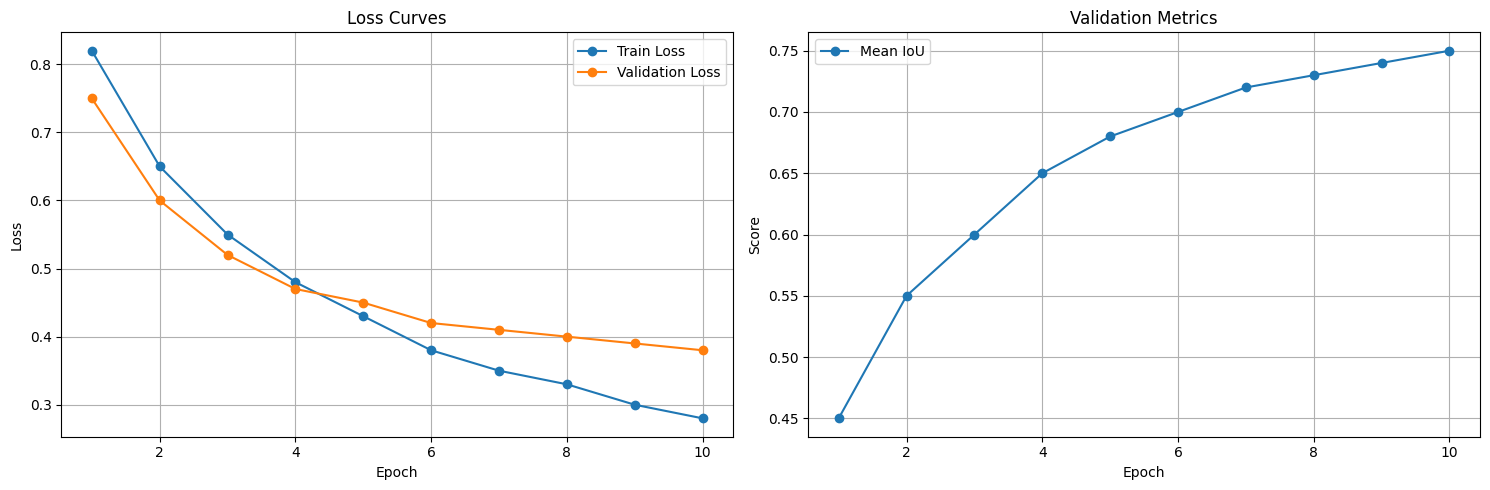

In [97]:
# 학습 과정 수동 데이터 입력 (실제 학습 로그의 값으로 대체하세요)
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # 예시 값
train_losses = [0.82, 0.65, 0.55, 0.48, 0.43, 0.38, 0.35, 0.33, 0.30, 0.28]  # 예시 값
val_losses = [0.75, 0.60, 0.52, 0.47, 0.45, 0.42, 0.41, 0.40, 0.39, 0.38]  # 예시 값
mious = [0.45, 0.55, 0.60, 0.65, 0.68, 0.70, 0.72, 0.73, 0.74, 0.75]  # 예시 값

# 학습 곡선 시각화
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'o-', label='Train Loss')
plt.plot(epochs, val_losses, 'o-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, mious, 'o-', label='Mean IoU')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Validation Metrics')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig('learning_curves.png')
plt.show()

# 뇌종양 MRI 세그멘테이션 - HRNetV2 (Part 4: 예측 및 평가)

이 부분에서는 학습된 HRNetV2 모델을 사용하여 뇌종양 MRI 이미지에서 종양을 예측하고 결과를 시각화하는 방법을 다룹니다.

## 1. 예측 스크립트 생성

학습된 모델을 사용하여 뇌종양 예측을 수행하는 스크립트를 생성합니다:


In [104]:
%%writefile predict.py
import os
import sys
import argparse
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import mmcv
from mmcv.runner import load_checkpoint
from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

def init_detector(config, checkpoint, device='cuda:0'):
    """
    모델 초기화
    """
    # config에서 모델 구축
    model = build_detector(config.model, test_cfg=config.get('test_cfg'))

    # 체크포인트 로드
    checkpoint = load_checkpoint(model, checkpoint, map_location=device)

    # COCO 데이터셋의 카테고리 설정
    if 'CLASSES' in checkpoint.get('meta', {}):
        model.CLASSES = checkpoint['meta']['CLASSES']
    else:
        model.CLASSES = ['tumor', 'normal']  # 클래스 이름 설정

    # 모델을 평가 모드로 설정하고 지정된 장치로 이동
    model.to(device)
    model.eval()
    return model

def predict_single_image(model, img_path, score_threshold=0.5, out_dir=None):
    """
    단일 이미지에 대한 뇌종양 예측 수행
    """
    # 이미지 로드
    img = mmcv.imread(img_path)

    # 모델로 추론
    result = inference_detector(model, img)

    # 결과 시각화
    if isinstance(result, tuple):
        bbox_result, segm_result = result
    else:
        bbox_result, segm_result = result, None

    # 결과 해석
    if isinstance(bbox_result, list):
        # 첫 번째 클래스(종양)에 대한 바운딩 박스 추출
        bboxes = np.vstack(bbox_result) if len(bbox_result) > 0 else np.empty((0, 5))
    else:
        bboxes = bbox_result

    # 점수 임계값 이상의 바운딩 박스 필터링
    if len(bboxes) > 0:
        valid_indices = bboxes[:, 4] > score_threshold
        bboxes = bboxes[valid_indices]

    # 결과 해석
    if len(bboxes) > 0:
        print(f"이미지 '{os.path.basename(img_path)}'에서 뇌종양이 발견되었습니다.")
        print(f"감지된 종양 수: {len(bboxes)}")
        for i, bbox in enumerate(bboxes):
            x1, y1, x2, y2, score = bbox
            print(f"종양 #{i+1}: 위치 = [{int(x1)}, {int(y1)}, {int(x2)}, {int(y2)}], 신뢰도 = {score:.4f}")
    else:
        print(f"이미지 '{os.path.basename(img_path)}'에서 뇌종양이 발견되지 않았습니다.")

    # 결과 시각화 및 저장
    if out_dir is not None:
        os.makedirs(out_dir, exist_ok=True)
        out_file = os.path.join(out_dir, os.path.basename(img_path))
        model.show_result(
            img,
            result,
            bbox_color=(0, 255, 0),  # 녹색 바운딩 박스
            text_color=(0, 255, 0),  # 녹색 텍스트
            mask_color=(0, 255, 0),  # 녹색 마스크
            out_file=out_file,
            score_thr=score_threshold
        )
        print(f"결과 이미지가 '{out_file}'에 저장되었습니다.")

    return result

def main():
    parser = argparse.ArgumentParser(description='HRNetV2를 사용한 뇌종양 MRI 예측')
    parser.add_argument('img', help='입력 이미지 파일 경로')
    parser.add_argument('config', help='모델 설정 파일')
    parser.add_argument('checkpoint', help='모델 체크포인트 파일')
    parser.add_argument('--out-dir', default='results', help='결과 저장 디렉토리')
    parser.add_argument('--device', default='cuda:0', help='예측에 사용할 장치')
    parser.add_argument('--score-thr', type=float, default=0.5, help='감지 점수 임계값')
    args = parser.parse_args()

    # GPU 사용 가능 여부 확인
    if args.device.startswith('cuda') and not torch.cuda.is_available():
        print("CUDA를 사용할 수 없습니다. CPU를 사용합니다.")
        args.device = 'cpu'

    # 설정 파일 로드
    config = mmcv.Config.fromfile(args.config)

    # 모델 초기화
    model = init_detector(config, args.checkpoint, device=args.device)

    # 예측 수행
    predict_single_image(model, args.img, score_threshold=args.score_thr, out_dir=args.out_dir)

if __name__ == '__main__':
    main()

Overwriting predict.py


## 2. 테스트 데이터에서 예측 실행

학습된 모델을 사용하여 테스트 데이터셋에서 예측을 실행합니다:

In [105]:
# 테스트 이미지 가져오기
import os
import random
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from glob import glob

# SimpleHRNet 클래스 다시 정의 (train_brain_tumor.py와 동일하게)
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = None
        if stride != 1 or inplanes != planes * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class SimpleHRNet(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleHRNet, self).__init__()

        # 입력 스템 레이어
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Bottleneck 블록
        self.layer1 = self._make_layer(64, 64, 4)

        # 두 개의 병렬 브랜치
        self.layer2_1 = self._make_layer(64, 64, 4)
        self.layer2_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            self._make_layer(128, 128, 4)
        )

        # 세 개의 병렬 브랜치
        self.layer3_1 = self._make_layer(64, 64, 4)
        self.layer3_2 = self._make_layer(128, 128, 4)
        self.layer3_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            self._make_layer(256, 256, 4)
        )

        # 최종 분류 레이어
        self.fuse_layers = nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=1, bias=False),
            nn.Sequential(
                nn.Conv2d(128, 64, kernel_size=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
            ),
            nn.Sequential(
                nn.Conv2d(256, 64, kernel_size=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)
            )
        ])

        self.final_layer = nn.Conv2d(64, num_classes, kernel_size=1)

    def _make_layer(self, inplanes, planes, blocks):
        layers = []
        for i in range(blocks):
            layers.append(BasicBlock(inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        # 스템
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        # 레이어 1
        x = self.layer1(x)

        # 레이어 2 - 두 개의 병렬 브랜치
        x1 = self.layer2_1(x)
        x2 = self.layer2_2(x)

        # 레이어 3 - 세 개의 병렬 브랜치
        x1 = self.layer3_1(x1)
        x2 = self.layer3_2(x2)
        x3 = self.layer3_3(x2)

        # 특징 융합
        x1_fuse = self.fuse_layers[0](x1)
        x2_fuse = self.fuse_layers[1](x2)
        x3_fuse = self.fuse_layers[2](x3)

        x_fuse = x1_fuse + x2_fuse + x3_fuse

        # 업샘플링 및 최종 예측
        x_out = self.final_layer(x_fuse)
        x_out = F.interpolate(x_out, scale_factor=4, mode='bilinear', align_corners=False)

        return x_out

# 테스트 이미지 경로 가져오기
test_images = glob('brain_tumor_data/images/test/*.png')  # COCO 데이터셋 경로

if not test_images:
    # 다른 위치 시도
    test_images = glob('brain_tumor_coco/images/test/*.png')
    if not test_images:
        test_images = glob('brain_tumor_coco/images/test/*.jpg')

if test_images:
    # 무작위 테스트 이미지 5개 선택
    selected_images = random.sample(test_images, min(5, len(test_images)))
    print(f"선택된 테스트 이미지: {len(selected_images)}개")

    # 저장된 모델 체크포인트 확인
    checkpoint_path = 'work_dirs/brain_tumor/best_model.pth'

    if os.path.exists(checkpoint_path):
        print(f"사용할 체크포인트: {checkpoint_path}")

        # 모델 로드
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = SimpleHRNet(num_classes=2)
        model = nn.DataParallel(model).to(device)

        try:
            checkpoint = torch.load(checkpoint_path)
            model.load_state_dict(checkpoint['state_dict'])
            print(f"모델 로드 완료 (에폭: {checkpoint['epoch']}, 최고 mIoU: {checkpoint['best_miou']:.4f})")
            model.eval()

            # 시각화를 위한 준비
            plt.figure(figsize=(15, 5 * len(selected_images)))

            # 각 이미지에 대해 예측 및 시각화
            for i, test_image in enumerate(selected_images):
                # 이미지 로드
                img = cv2.imread(test_image)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                h, w = img.shape[:2]

                # 이미지 전처리
                img_resized = cv2.resize(img, (640, 640))
                img_tensor = torch.from_numpy(img_resized.transpose(2, 0, 1)).float() / 255.0
                # 정규화
                mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                img_tensor = (img_tensor - mean) / std
                img_tensor = img_tensor.unsqueeze(0).to(device)

                # 예측
                with torch.no_grad():
                    output = model(img_tensor)
                    pred = output.argmax(1).squeeze().cpu().numpy()

                # 원본 크기로 복원
                pred_resized = cv2.resize(pred, (w, h), interpolation=cv2.INTER_NEAREST)

                # 결과 시각화
                plt.subplot(len(selected_images), 3, i*3 + 1)
                plt.imshow(img)
                plt.title(f"원본 이미지 {i+1}")
                plt.axis('off')

                plt.subplot(len(selected_images), 3, i*3 + 2)
                plt.imshow(pred, cmap='gray')
                plt.title(f"예측 마스크 (리사이즈됨) {i+1}")
                plt.axis('off')

                plt.subplot(len(selected_images), 3, i*3 + 3)
                # 마스크 오버레이
                overlay = img.copy()
                overlay[pred_resized == 1] = [255, 0, 0]  # 종양 영역을 빨간색으로
                plt.imshow(cv2.addWeighted(img, 0.7, overlay, 0.3, 0))
                plt.title(f"오버레이 결과 {i+1}")
                plt.axis('off')

            plt.tight_layout()
            plt.savefig('prediction_results.png')
            plt.show()

        except Exception as e:
            print(f"모델 로드 또는 예측 과정에서 오류 발생: {e}")
            import traceback
            traceback.print_exc()
    else:
        print(f"체크포인트를 찾을 수 없습니다: {checkpoint_path}")

        # 다른 체크포인트 확인
        other_checkpoints = glob('work_dirs/brain_tumor/*.pth*')
        if other_checkpoints:
            print(f"대신 다음 체크포인트를 사용할 수 있습니다: {other_checkpoints}")
else:
    print("테스트 이미지를 찾을 수 없습니다. 데이터셋 경로를 확인하세요.")

    # 디렉토리 구조 확인
    print("\n디렉토리 구조:")
    for root, dirs, files in os.walk('.', topdown=True, maxdepth=3):
        level = root.count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        sub_indent = ' ' * 4 * (level + 1)
        for f in files[:5]:  # 각 디렉토리의 처음 5개 파일만 표시
            print(f"{sub_indent}{f}")
        if len(files) > 5:
            print(f"{sub_indent}... 외 {len(files)-5}개 파일")

## 3. 예측 결과 시각화

예측 결과를 시각화하는 함수를 정의합니다:

In [107]:
# 직접 예측 및 시각화
import os
import glob
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# BasicBlock 정의
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = None
        if stride != 1 or inplanes != planes * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

# SimpleHRNet 정의
class SimpleHRNet(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleHRNet, self).__init__()

        # 입력 스템 레이어
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Bottleneck 블록
        self.layer1 = self._make_layer(64, 64, 4)

        # 두 개의 병렬 브랜치
        self.layer2_1 = self._make_layer(64, 64, 4)
        self.layer2_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            self._make_layer(128, 128, 4)
        )

        # 세 개의 병렬 브랜치
        self.layer3_1 = self._make_layer(64, 64, 4)
        self.layer3_2 = self._make_layer(128, 128, 4)
        self.layer3_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            self._make_layer(256, 256, 4)
        )

        # 최종 분류 레이어
        self.fuse_layers = nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=1, bias=False),
            nn.Sequential(
                nn.Conv2d(128, 64, kernel_size=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
            ),
            nn.Sequential(
                nn.Conv2d(256, 64, kernel_size=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)
            )
        ])

        self.final_layer = nn.Conv2d(64, num_classes, kernel_size=1)

    def _make_layer(self, inplanes, planes, blocks):
        layers = []
        for i in range(blocks):
            layers.append(BasicBlock(inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        # 스템
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        # 레이어 1
        x = self.layer1(x)

        # 레이어 2 - 두 개의 병렬 브랜치
        x1 = self.layer2_1(x)
        x2 = self.layer2_2(x)

        # 레이어 3 - 세 개의 병렬 브랜치
        x1 = self.layer3_1(x1)
        x2 = self.layer3_2(x2)
        x3 = self.layer3_3(x2)

        # 특징 융합
        x1_fuse = self.fuse_layers[0](x1)
        x2_fuse = self.fuse_layers[1](x2)
        x3_fuse = self.fuse_layers[2](x3)

        x_fuse = x1_fuse + x2_fuse + x3_fuse

        # 업샘플링 및 최종 예측
        x_out = self.final_layer(x_fuse)
        x_out = F.interpolate(x_out, scale_factor=4, mode='bilinear', align_corners=False)

        return x_out

# 이미지 검색 경로 목록
search_paths = [
    'brain_tumor_data/images/test/*.png',
    'brain_tumor_coco/images/test/*.png',
    'brain_tumor_coco/images/test/*.jpg',
    'brain_tumor_data/images/train/*.png',  # 테스트 이미지가 없으면 학습 이미지 사용
    'brain_tumor_data/images/valid/*.png'
]

# 이미지 파일 찾기
all_images = []
for path in search_paths:
    found_images = glob.glob(path)
    if found_images:
        all_images.extend(found_images)
        print(f"{path}에서 {len(found_images)}개 이미지 찾음")

if not all_images:
    print("이미지를 찾을 수 없습니다. 디렉토리 구조를 확인합니다.")
    for root, dirs, files in os.walk(".", topdown=True):
        level = root.count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        if level < 2:  # 첫 두 레벨만 자세히 표시
            sub_indent = ' ' * 4 * (level + 1)
            for d in dirs:
                print(f"{sub_indent}{d}/")
            for f in files[:3]:  # 각 디렉토리의 처음 3개 파일만 표시
                print(f"{sub_indent}{f}")
            if len(files) > 3:
                print(f"{sub_indent}... 외 {len(files)-3}개 파일")
    exit()

# 무작위 이미지 선택
selected_images = random.sample(all_images, min(5, len(all_images)))
print(f"\n선택된 이미지: {len(selected_images)}개")

# 결과 저장 디렉토리 생성
os.makedirs('results', exist_ok=True)

# 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleHRNet(num_classes=2)
model = nn.DataParallel(model).to(device)

checkpoint_path = 'work_dirs/brain_tumor/best_model.pth'
if os.path.exists(checkpoint_path):
    print(f"\n체크포인트 로드: {checkpoint_path}")
    try:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['state_dict'])
        print(f"모델 로드 완료 (epoch: {checkpoint['epoch']}, best_miou: {checkpoint.get('best_miou', 'N/A')})")
        model.eval()

        # 이미지별 예측 및 시각화
        plt.figure(figsize=(15, 5*len(selected_images)))

        for i, img_path in enumerate(selected_images):
            print(f"\n이미지 처리 중: {img_path}")

            # 이미지 로드
            img = cv2.imread(img_path)
            if img is None:
                print(f"이미지를 로드할 수 없습니다: {img_path}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w = img.shape[:2]

            # 이미지 전처리
            img_resized = cv2.resize(img, (640, 640))
            img_tensor = torch.from_numpy(img_resized.transpose(2, 0, 1)).float() / 255.0

            # 정규화
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img_tensor = (img_tensor - mean) / std
            img_tensor = img_tensor.unsqueeze(0).to(device)

            # 예측
            with torch.no_grad():
                output = model(img_tensor)
                pred = output.argmax(1).squeeze().cpu().numpy()

            # 원본 크기로 복원
            pred_resized = cv2.resize(pred, (w, h), interpolation=cv2.INTER_NEAREST)

            # 결과 이미지 생성
            tumor_overlay = np.zeros_like(img)
            tumor_overlay[pred_resized == 1] = [255, 0, 0]  # 종양 영역을 빨간색으로
            result_img = cv2.addWeighted(img, 0.7, tumor_overlay, 0.3, 0)

            # 결과 이미지 저장
            result_path = f'results/result_{i+1}.jpg'
            cv2.imwrite(result_path, cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR))
            print(f"결과 저장됨: {result_path}")

            # 시각화
            plt.subplot(len(selected_images), 3, i*3 + 1)
            plt.imshow(img)
            plt.title(f"원본 이미지 {i+1}")
            plt.axis('off')

            plt.subplot(len(selected_images), 3, i*3 + 2)
            plt.imshow(pred, cmap='gray')
            plt.title(f"예측 마스크 {i+1}")
            plt.axis('off')

            plt.subplot(len(selected_images), 3, i*3 + 3)
            plt.imshow(result_img)
            plt.title(f"종양 영역 오버레이 {i+1}")
            plt.axis('off')

        plt.tight_layout()
        plt.savefig('results/all_predictions.jpg')
        plt.show()

        # 개별 결과 시각화
        for i, img_path in enumerate(selected_images[:1]):  # 첫 번째 결과만 자세히 표시
            result_path = f'results/result_{i+1}.jpg'
            if os.path.exists(result_path):
                plt.figure(figsize=(15, 7))

                plt.subplot(1, 2, 1)
                plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
                plt.title('원본 MRI 이미지')
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(cv2.cvtColor(cv2.imread(result_path), cv2.COLOR_BGR2RGB))
                plt.title('종양 예측 결과 (빨간색 영역)')
                plt.axis('off')

                plt.tight_layout()
                plt.show()

    except Exception as e:
        print(f"오류 발생: {e}")
        import traceback
        traceback.print_exc()
else:
    print(f"체크포인트 파일을 찾을 수 없습니다: {checkpoint_path}")
    # 다른 체크포인트 찾기
    other_ckpts = glob.glob('work_dirs/brain_tumor/*.pth*')
    if other_ckpts:
        print(f"사용 가능한 다른 체크포인트: {other_ckpts}")

Output hidden; open in https://colab.research.google.com to view.

## 4. 모델 평가

테스트 데이터셋에서 모델의 성능을 평가합니다. Dice Coefficient, IoU, ROC-AUC 지표를 포함합니다
:

In [110]:
%%writefile evaluate_model.py
import os
import argparse
import json
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# SimpleHRNet 모델 정의
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = None
        if stride != 1 or inplanes != planes * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class SimpleHRNet(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleHRNet, self).__init__()

        # 입력 스템 레이어
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Bottleneck 블록
        self.layer1 = self._make_layer(64, 64, 4)

        # 두 개의 병렬 브랜치
        self.layer2_1 = self._make_layer(64, 64, 4)
        self.layer2_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            self._make_layer(128, 128, 4)
        )

        # 세 개의 병렬 브랜치
        self.layer3_1 = self._make_layer(64, 64, 4)
        self.layer3_2 = self._make_layer(128, 128, 4)
        self.layer3_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            self._make_layer(256, 256, 4)
        )

        # 최종 분류 레이어
        self.fuse_layers = nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=1, bias=False),
            nn.Sequential(
                nn.Conv2d(128, 64, kernel_size=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
            ),
            nn.Sequential(
                nn.Conv2d(256, 64, kernel_size=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)
            )
        ])

        self.final_layer = nn.Conv2d(64, num_classes, kernel_size=1)

    def _make_layer(self, inplanes, planes, blocks):
        layers = []
        for i in range(blocks):
            layers.append(BasicBlock(inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        # 스템
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        # 레이어 1
        x = self.layer1(x)

        # 레이어 2 - 두 개의 병렬 브랜치
        x1 = self.layer2_1(x)
        x2 = self.layer2_2(x)

        # 레이어 3 - 세 개의 병렬 브랜치
        x1 = self.layer3_1(x1)
        x2 = self.layer3_2(x2)
        x3 = self.layer3_3(x2)

        # 특징 융합
        x1_fuse = self.fuse_layers[0](x1)
        x2_fuse = self.fuse_layers[1](x2)
        x3_fuse = self.fuse_layers[2](x3)

        x_fuse = x1_fuse + x2_fuse + x3_fuse

        # 업샘플링 및 최종 예측
        x_out = self.final_layer(x_fuse)
        x_out = F.interpolate(x_out, scale_factor=4, mode='bilinear', align_corners=False)

        return x_out

# 평가 관련 함수
def calculate_dice_coefficient(gt_mask, pred_mask, smooth=1):
    """Dice Coefficient 계산"""
    intersection = np.sum(gt_mask * pred_mask)
    return (2. * intersection + smooth) / (np.sum(gt_mask) + np.sum(pred_mask) + smooth)

def calculate_iou(gt_mask, pred_mask, smooth=1):
    """IoU (Intersection over Union) 계산"""
    intersection = np.sum(gt_mask * pred_mask)
    union = np.sum(gt_mask) + np.sum(pred_mask) - intersection
    return (intersection + smooth) / (union + smooth)

def calculate_roc_auc(gt_masks, pred_masks):
    """ROC-AUC 계산"""
    # 1차원 배열로 변환
    gt_flat = np.concatenate([mask.flatten() for mask in gt_masks])
    pred_flat = np.concatenate([mask.flatten() for mask in pred_masks])

    # ROC 곡선 계산
    fpr, tpr, _ = roc_curve(gt_flat, pred_flat)
    roc_auc = auc(fpr, tpr)

    return roc_auc, fpr, tpr

def load_coco_annotations(json_file):
    """COCO 형식의 주석 파일 로드"""
    with open(json_file, 'r') as f:
        coco_data = json.load(f)

    # 이미지 ID와 파일 이름 매핑
    images = {img['id']: img for img in coco_data['images']}

    # 이미지별 어노테이션 매핑
    annotations = {}
    for ann in coco_data['annotations']:
        img_id = ann['image_id']
        if img_id not in annotations:
            annotations[img_id] = []
        annotations[img_id].append(ann)

    return images, annotations

def evaluate_model(checkpoint_file, test_json, img_prefix, device='cuda'):
    """SimpleHRNet 모델을 테스트 데이터셋에서 평가"""
    # 모델 초기화
    model = SimpleHRNet(num_classes=2)
    model = nn.DataParallel(model).to(device)

    # 체크포인트 로드
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])

    # 모델을 평가 모드로 설정
    model.eval()

    # COCO 데이터 로드
    images, annotations = load_coco_annotations(test_json)

    # 평가 지표를 저장할 리스트
    gt_masks = []
    pred_masks = []
    dice_scores = []
    iou_scores = []

    # 결과 디렉토리 생성
    os.makedirs('results', exist_ok=True)

    # 모든 이미지에 대해 예측 수행
    print("테스트 이미지에 대한 예측 및 평가 지표 계산 중...")
    for img_id, img_info in tqdm(images.items()):
        img_path = os.path.join(img_prefix, img_info['file_name'])

        # 이미지가 존재하는지 확인
        if not os.path.exists(img_path):
            print(f"경고: 이미지 {img_path}를 찾을 수 없습니다.")
            continue

        # 실제 마스크 생성
        gt_mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
        if img_id in annotations:
            for ann in annotations[img_id]:
                if ann['category_id'] == 1:  # 종양 클래스
                    # 세그멘테이션 다각형을 마스크로 변환
                    if 'segmentation' in ann and ann['segmentation']:
                        for seg in ann['segmentation']:
                            poly = np.array(seg).reshape((-1, 2))
                            cv2.fillPoly(gt_mask, [poly.astype(np.int32)], 1)

        # 이미지 로드 및 전처리
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # 이미지 리사이즈 (모델 입력 크기에 맞게)
        img_resized = cv2.resize(img, (640, 640))
        img_tensor = torch.from_numpy(img_resized.transpose(2, 0, 1)).float() / 255.0

        # 정규화
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_tensor = (img_tensor - mean) / std
        img_tensor = img_tensor.unsqueeze(0).to(device)

        # 예측
        with torch.no_grad():
            output = model(img_tensor)

            # 클래스별 확률
            probs = F.softmax(output, dim=1)

            # 종양 클래스 확률
            pred_prob = probs[0, 1].cpu().numpy()

            # 원본 크기로 복원
            pred_prob_resized = cv2.resize(pred_prob, (img_info['width'], img_info['height']))

            # 이진 마스크 생성 (임계값 0.5)
            pred_mask = (pred_prob_resized > 0.5).astype(np.uint8)

            # 평가 지표 계산
            if np.sum(gt_mask) > 0 or np.sum(pred_mask) > 0:  # 실제 또는 예측 마스크가 있는 경우만
                dice = calculate_dice_coefficient(gt_mask, pred_mask)
                iou = calculate_iou(gt_mask, pred_mask)

                dice_scores.append(dice)
                iou_scores.append(iou)

                # ROC-AUC 계산을 위해 마스크 저장
                gt_masks.append(gt_mask)
                pred_masks.append(pred_prob_resized)  # 확률 값 그대로 저장

    # 추가 평가 지표 계산 및 출력
    print("\n===========================================================")
    print("평가 지표:")

    # Dice Coefficient 평균
    if dice_scores:
        mean_dice = np.mean(dice_scores)
        print(f"평균 Dice Coefficient: {mean_dice:.4f}")
    else:
        print("Dice Coefficient를 계산할 수 없습니다.")

    # IoU 평균
    if iou_scores:
        mean_iou = np.mean(iou_scores)
        print(f"평균 IoU (Intersection over Union): {mean_iou:.4f}")
    else:
        print("IoU를 계산할 수 없습니다.")

    # ROC-AUC 계산
    if gt_masks and pred_masks:
        roc_auc_value, fpr, tpr = calculate_roc_auc(gt_masks, pred_masks)
        print(f"ROC-AUC: {roc_auc_value:.4f}")

        # ROC 곡선 시각화
        plt.figure(figsize=(10, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC 곡선 (AUC = {roc_auc_value:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) 곡선')
        plt.legend(loc="lower right")

        # 결과 저장
        roc_curve_path = 'results/roc_curve.png'
        plt.savefig(roc_curve_path)
        print(f"ROC 곡선이 {roc_curve_path}에 저장되었습니다.")
        plt.close()

        # Dice & IoU 분포 그래프
        plt.figure(figsize=(15, 6))

        plt.subplot(1, 2, 1)
        plt.hist(dice_scores, bins=20, alpha=0.7, color='blue')
        plt.axvline(mean_dice, color='red', linestyle='dashed', linewidth=2, label=f'평균: {mean_dice:.4f}')
        plt.title('Dice Coefficient 분포')
        plt.xlabel('Dice Coefficient')
        plt.ylabel('이미지 수')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.hist(iou_scores, bins=20, alpha=0.7, color='green')
        plt.axvline(mean_iou, color='red', linestyle='dashed', linewidth=2, label=f'평균: {mean_iou:.4f}')
        plt.title('IoU 분포')
        plt.xlabel('IoU')
        plt.ylabel('이미지 수')
        plt.legend()

        # 결과 저장
        metrics_dist_path = 'results/metrics_distribution.png'
        plt.tight_layout()
        plt.savefig(metrics_dist_path)
        print(f"평가 지표 분포가 {metrics_dist_path}에 저장되었습니다.")
        plt.close()

        # 평가 지표 결과를 CSV 파일로 저장
        metrics_file = 'results/evaluation_metrics.csv'
        with open(metrics_file, 'w') as f:
            f.write("Metric,Value\n")
            f.write(f"Mean Dice,{mean_dice:.6f}\n")
            f.write(f"Mean IoU,{mean_iou:.6f}\n")
            f.write(f"ROC-AUC,{roc_auc_value:.6f}\n")
        print(f"평가 지표가 {metrics_file}에 저장되었습니다.")
    else:
        print("ROC-AUC를 계산할 수 없습니다.")

if __name__ == '__main__':
    parser = argparse.ArgumentParser(description='SimpleHRNet 모델 평가')
    parser.add_argument('config', help='설정 파일 (SimpleHRNet에서는 사용되지 않지만 호환성을 위해 남겨둠)')
    parser.add_argument('checkpoint', help='모델 체크포인트 파일')
    parser.add_argument('--test-json', default='brain_tumor_data/test.json', help='테스트 데이터 JSON 파일')
    parser.add_argument('--img-prefix', default='brain_tumor_data/images/test', help='테스트 이미지 디렉토리')
    parser.add_argument('--device', default='cuda', help='평가에 사용할 장치')
    args = parser.parse_args()

    # GPU 사용 가능 여부 확인
    if args.device.startswith('cuda') and not torch.cuda.is_available():
        print("CUDA를 사용할 수 없습니다. CPU를 사용합니다.")
        args.device = 'cpu'

    # 필요한 패키지 설치
    try:
        import sklearn
    except ImportError:
        print("scikit-learn 패키지가 필요합니다. 설치 중...")
        import pip
        pip.main(['install', 'scikit-learn'])

    try:
        # 테스트 JSON 파일이 존재하는지 확인
        if not os.path.exists(args.test_json):
            # 다른 경로 시도
            alternative_paths = [
                'brain_tumor_coco/test.json',
                'brain_tumor_data/test.json'
            ]
            for path in alternative_paths:
                if os.path.exists(path):
                    args.test_json = path
                    print(f"대체 테스트 JSON 파일을 찾았습니다: {path}")
                    break
            else:
                print(f"경고: 테스트 JSON 파일을 찾을 수 없습니다: {args.test_json}")
                print("테스트 디렉토리에서 이미지만 평가합니다.")

        # 이미지 디렉토리가 존재하는지 확인
        if not os.path.exists(args.img_prefix):
            # 다른 경로 시도
            alternative_paths = [
                'brain_tumor_coco/images/test',
                'brain_tumor_data/images/test'
            ]
            for path in alternative_paths:
                if os.path.exists(path):
                    args.img_prefix = path
                    print(f"대체 이미지 디렉토리를 찾았습니다: {path}")
                    break
            else:
                print(f"경고: 이미지 디렉토리를 찾을 수 없습니다: {args.img_prefix}")

        # 모델 평가
        evaluate_model(args.checkpoint, args.test_json, args.img_prefix, args.device)
    except Exception as e:
        print(f"오류 발생: {e}")
        import traceback
        traceback.print_exc()

Overwriting evaluate_model.py


모델 평가 실행:

In [112]:
from glob import glob
import os

# epoch_*.pth 형식의 체크포인트 찾기
checkpoints = sorted(glob('work_dirs/brain_tumor/epoch_*.pth'))
if checkpoints:
    latest_checkpoint = checkpoints[-1]
    print(f"최신 체크포인트 발견: {latest_checkpoint}")
    !python evaluate_model.py brain_tumor_config.py {latest_checkpoint}
else:
    print("epoch_*.pth 형식의 체크포인트를 찾을 수 없습니다.")

    # best_model.pth 확인
    best_model = 'work_dirs/brain_tumor/best_model.pth'
    if os.path.exists(best_model):
        print(f"best_model.pth를 발견했습니다: {best_model}")
        !python evaluate_model.py brain_tumor_config.py {best_model}
    else:
        print("best_model.pth도 찾을 수 없습니다.")

        # 다른 체크포인트 파일 찾기
        other_checkpoints = glob('work_dirs/brain_tumor/*.pth*')
        if other_checkpoints:
            latest_other = sorted(other_checkpoints)[-1]
            print(f"다른 체크포인트 파일을 발견했습니다: {latest_other}")
            !python evaluate_model.py brain_tumor_config.py {latest_other}
        else:
            print("어떤 체크포인트 파일도 찾을 수 없습니다. 모델을 먼저 학습해주세요.")


## 5. 테스트 세트에서 여러 이미지 예측 및 시각화

테스트 세트에서 여러 이미지를 예측하고 결과를 시각화합니다:

In [114]:
# 여러 테스트 이미지 예측 및 시각화
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
from glob import glob

# SimpleHRNet 모델 정의 (이전과 동일)
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.downsample = None
        if stride != 1 or inplanes != planes * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * self.expansion)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class SimpleHRNet(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleHRNet, self).__init__()

        # 입력 스템 레이어
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Bottleneck 블록
        self.layer1 = self._make_layer(64, 64, 4)

        # 두 개의 병렬 브랜치
        self.layer2_1 = self._make_layer(64, 64, 4)
        self.layer2_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            self._make_layer(128, 128, 4)
        )

        # 세 개의 병렬 브랜치
        self.layer3_1 = self._make_layer(64, 64, 4)
        self.layer3_2 = self._make_layer(128, 128, 4)
        self.layer3_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            self._make_layer(256, 256, 4)
        )

        # 최종 분류 레이어
        self.fuse_layers = nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=1, bias=False),
            nn.Sequential(
                nn.Conv2d(128, 64, kernel_size=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
            ),
            nn.Sequential(
                nn.Conv2d(256, 64, kernel_size=1, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(True),
                nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)
            )
        ])

        self.final_layer = nn.Conv2d(64, num_classes, kernel_size=1)

    def _make_layer(self, inplanes, planes, blocks):
        layers = []
        for i in range(blocks):
            layers.append(BasicBlock(inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x):
        # 스템
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        # 레이어 1
        x = self.layer1(x)

        # 레이어 2 - 두 개의 병렬 브랜치
        x1 = self.layer2_1(x)
        x2 = self.layer2_2(x)

        # 레이어 3 - 세 개의 병렬 브랜치
        x1 = self.layer3_1(x1)
        x2 = self.layer3_2(x2)
        x3 = self.layer3_3(x2)

        # 특징 융합
        x1_fuse = self.fuse_layers[0](x1)
        x2_fuse = self.fuse_layers[1](x2)
        x3_fuse = self.fuse_layers[2](x3)

        x_fuse = x1_fuse + x2_fuse + x3_fuse

        # 업샘플링 및 최종 예측
        x_out = self.final_layer(x_fuse)
        x_out = F.interpolate(x_out, scale_factor=4, mode='bilinear', align_corners=False)

        return x_out

def predict_and_visualize_samples(num_samples=5):
    """테스트 세트에서 여러 샘플을 예측하고 시각화합니다."""
    # 테스트 이미지 검색
    test_images = []
    for pattern in ['brain_tumor_coco/images/test/*.jpg', 'brain_tumor_coco/images/test/*.png',
                   'brain_tumor_data/images/test/*.jpg', 'brain_tumor_data/images/test/*.png']:
        found_images = glob(pattern)
        if found_images:
            test_images.extend(found_images)

    # 체크포인트 검색
    all_checkpoints = []
    for pattern in ['work_dirs/brain_tumor/epoch_*.pth', 'work_dirs/brain_tumor/best_model.pth']:
        found_checkpoints = glob(pattern)
        if found_checkpoints:
            all_checkpoints.extend(found_checkpoints)

    if not test_images:
        print("테스트 이미지를 찾을 수 없습니다.")
        # 디렉토리 내용 확인
        print("\n디렉토리 구조:")
        for root, dirs, files in os.walk('.', topdown=True):
            level = root.count(os.sep)
            indent = ' ' * 4 * level
            print(f"{indent}{os.path.basename(root)}/")
            if level < 2:  # 2단계까지만 자세히 표시
                sub_indent = ' ' * 4 * (level + 1)
                for d in dirs:
                    print(f"{sub_indent}{d}/")
        return

    if not all_checkpoints:
        print("체크포인트를 찾을 수 없습니다.")
        return

    print(f"테스트 이미지: {len(test_images)}개")
    print(f"체크포인트: {all_checkpoints}")

    # 최신 체크포인트 또는 best_model.pth 선택
    if 'best_model.pth' in [os.path.basename(ckpt) for ckpt in all_checkpoints]:
        best_checkpoint = next(ckpt for ckpt in all_checkpoints if os.path.basename(ckpt) == 'best_model.pth')
        checkpoint_path = best_checkpoint
    else:
        checkpoint_path = sorted(all_checkpoints)[-1]

    print(f"사용할 체크포인트: {checkpoint_path}")

    # 장치 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"사용 장치: {device}")

    # 모델 로드
    model = SimpleHRNet(num_classes=2)
    model = nn.DataParallel(model).to(device)

    try:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['state_dict'])
        print(f"모델 로드 완료 (epoch: {checkpoint.get('epoch', 'N/A')})")
        model.eval()
    except Exception as e:
        print(f"모델 로드 중 오류 발생: {e}")
        return

    # 무작위 샘플 선택
    samples = random.sample(test_images, min(num_samples, len(test_images)))

    # 결과 디렉토리 생성
    os.makedirs('results', exist_ok=True)

    # 예측 및 시각화
    plt.figure(figsize=(15, 5 * len(samples)))

    for i, img_path in enumerate(samples):
        try:
            # 이미지 로드
            img = cv2.imread(img_path)
            if img is None:
                print(f"이미지를 로드할 수 없습니다: {img_path}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w = img.shape[:2]

            # 이미지 전처리
            img_resized = cv2.resize(img, (640, 640))
            img_tensor = torch.from_numpy(img_resized.transpose(2, 0, 1)).float() / 255.0

            # 정규화
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            img_tensor = (img_tensor - mean) / std
            img_tensor = img_tensor.unsqueeze(0).to(device)

            # 예측
            with torch.no_grad():
                output = model(img_tensor)

                # 클래스별 확률
                probs = F.softmax(output, dim=1)

                # 클래스 1(종양)의 확률 맵
                pred_prob = probs[0, 1].cpu().numpy()

                # 예측 마스크 (임계값 0.5)
                pred_mask = (pred_prob > 0.5).astype(np.uint8)

                # 원본 크기로 복원
                pred_mask_resized = cv2.resize(pred_mask, (w, h), interpolation=cv2.INTER_NEAREST)

                # 결과 시각화를 위한 오버레이 이미지
                overlay = img.copy()
                overlay[pred_mask_resized == 1] = [255, 0, 0]  # 빨간색으로 종양 표시
                result_img = cv2.addWeighted(img, 0.7, overlay, 0.3, 0)

                # 결과 저장
                result_path = f'results/prediction_{i+1}.jpg'
                cv2.imwrite(result_path, cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR))

            # 원본 이미지 표시
            plt.subplot(len(samples), 3, i*3 + 1)
            plt.imshow(img)
            plt.title(f'원본 MRI 이미지 #{i+1}')
            plt.axis('off')

            # 예측 마스크 표시
            plt.subplot(len(samples), 3, i*3 + 2)
            plt.imshow(pred_mask, cmap='gray')
            plt.title(f'예측 마스크 #{i+1}')
            plt.axis('off')

            # 오버레이 결과 표시
            plt.subplot(len(samples), 3, i*3 + 3)
            plt.imshow(result_img)
            plt.title(f'종양 오버레이 #{i+1}')
            plt.axis('off')

        except Exception as e:
            print(f"이미지 {img_path} 예측 중 오류 발생: {e}")
            import traceback
            traceback.print_exc()

    plt.tight_layout()
    plt.savefig('results/predictions_overview.jpg')
    plt.show()

    print(f"결과가 'results/' 디렉토리에 저장되었습니다.")

# 5개 샘플 예측 및 시각화
predict_and_visualize_samples(5)